In [ ]:
# Optional: change Jupyter Notebook theme to GDD theme
from IPython.core.display import HTML
HTML(url='https://gdd.li/jupyter-theme')

![footer_logo](images/logo.png)
# Time Series Analysis


## Goal

Pandas is the core data manipulation and analysis library for Python and it has some amazing utilities for dealing with series time data. 

The goal of this notebook is to familiarise ourselves with how Pandas can be used to work with Time Series data. 

We shall use a real Time Series dataset to demonstrate these functionalities and learn some fundamental techniques for Time Series analysis.

## Program
1. [Time Utilities in Pandas](#timeutil)
2. [Reading in Time Series Data](#read)
3. [Time-based Manipulations](#mani)
4. [Smoothing](#roll)
5. [Summary](#sum)


In [1]:
import pandas as pd

<a id='timeutil'></a>

## 1. Time Utilities in Pandas

### Timestamps
![footer_logo](images/clock.jpeg)

In pandas, specific times are represented as **Timestamps**. A Timestamp is the pandas equivalent of python’s Datetime and is interchangeable with it in most cases.

Pandas can create datetime data from strings formated as `'yyyy-mm-ddThh:mm:ss:ms'` using `pd.Timestamp()`. The date units are years (‘Y’), months (‘M’), weeks (‘W’), and days (‘D’), while the time units are hours (‘h’) in 24 hour format, minutes (‘m’), seconds (‘s’), milliseconds (‘ms’). Note that time units are combined with date units using `'T'

In [2]:
date = pd.Timestamp('2022-03-26T09:00:00')
print(f'the date is {date.date()} and the time is {date.time()}')
date

the date is 2022-03-26 and the time is 09:00:00


Timestamp('2022-03-26 09:00:00')

Pandas Timestamps support a wide range of [operations](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html).

For example, we can access various attributes stored in the Timestamp.

In [3]:
pd.Timestamp('2022-02-20T18:34:56').daysinmonth

28

In [4]:
pd.Timestamp('2022-02-20T18:34:56').weekofyear

7

In [5]:
pd.Timestamp('2022-02-20T18:34:56').quarter

1

We can also perform time based operations and use time related methods.

In [6]:
pd.Timestamp('2022-02-20T18:34:56') - pd.Timestamp('2020-02-18T18:24:32')

Timedelta('733 days 00:10:24')

In [7]:
pd.Timestamp('2022-02-20T18:34:56').month_name()

'February'

In [8]:
pd.Timestamp('2022-02-20T18:34:56').day_name()

'Sunday'

<a id='ex'></a>
### <mark>Exercise: Investigate the timestamp features and methods

We've seen a few examples, but let's investigate further.
- What day of the year is it today
- Are we in a leap year?
- How long is it until a Public Holiday (e.g. Christmas)?


In [9]:
current_date = pd.Timestamp('today')
current_date

Timestamp('2022-03-26 09:19:42.921116')

In [10]:
current_date.dayofyear

85

In [14]:
pd.Timestamp('2022-02-25T21:00:00').daysinmonth

28

In [13]:
pd.Timestamp('2022-12-25T21:00:00') - current_date

Timedelta('274 days 11:40:17.078884')

### Formatting Timestamps 

Pandas can recognize timestamps written in various common formats with `pd.to_datetime`, even if the data contains a mix of formats:

In [15]:
pd.to_datetime(['2020-03-27','April 1, 2020', '25/05/2020'])

DatetimeIndex(['2020-03-27', '2020-04-01', '2020-05-25'], dtype='datetime64[ns]', freq=None)

*`DatetimeIndex` is an array of Timestamps, which also contains metadata about it*.

Pandas will try to recognize the right format in a sequence of timestamps, though in some cases it may read data not as  you may have intended:

In [16]:
pd.to_datetime(['02/01/2020','03/01/2020'])

DatetimeIndex(['2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq=None)

To avoid such confusion, Timestamps can be explicitly formated with the `format` option. We recommend to always do this, rather than relying on Pandas figuring it out right for you. This way you can easily deal with even quite unconventional formats:

In [17]:
pd.to_datetime('02__2020xxx01', format='%m__%Yxxx%d')

Timestamp('2020-02-01 00:00:00')

Another good thing about fixed formatting - we want to know if single dates are unexpectedly in a wrong format. With a fixed formatting we will get an error raised for each such case rather than relying on Pandas figuring it out for us.

<a id='read'></a>
![footer_logo](images/air-quality.jpeg) 


## 2. Reading in Time Series Data


Throughout this taster will use a dataset containing daily air quality index in Californian counties between 2007 and 2017 (based on a larger dataset from [Kaggle](https://www.kaggle.com/epa/carbon-monoxide)). 

Each datapoint indicates the average air quality index on a certain day: the higher the value - the more polluted.

In [18]:
air_df = pd.read_csv('data/air_quality.csv')
air_df.head()

,date_local,aqi
0,2007-08-01,5.522124
1,2007-08-02,5.894895
2,2007-08-03,5.928358
3,2007-08-04,5.792285
4,2007-08-05,5.744807


Typically time data is contained in a separate column of standard strings; notice how our time data is not currently recognised as Timestamps.

In [19]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3562 entries, 0 to 3561
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_local  3562 non-null   object 
 1   aqi         3562 non-null   float64
dtypes: float64(1), object(1)
memory usage: 55.8+ KB


In order to make our time data machine readable, we can set `parse_dates` with the list of columns to be converted to Pandas Timestamps when reading the data with `pd.read_csv`. This automatically identifies the format of the dates, although specific formatting is also possible.

For most time-series analysis functionality, we also benefit from setting the dates as the index in the Pandas DataFrame. 

In [20]:
air_df = pd.read_csv('data/air_quality.csv', index_col='date_local', parse_dates=True)
air_df.head()

,aqi
date_local,
2007-08-01,5.522124
2007-08-02,5.894895
2007-08-03,5.928358
2007-08-04,5.792285
2007-08-05,5.744807


In [21]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3562 entries, 2007-08-01 to 2017-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aqi     3562 non-null   float64
dtypes: float64(1)
memory usage: 55.7 KB


With the Timestamps as the index, we can directly filter on our DataFrame using the`loc` method and easily produce plots to visualise our data.

In [22]:
air_df.loc['2008-02-01':'2008-02-10']

,aqi
date_local,
2008-02-01,9.341598
2008-02-02,8.629834
2008-02-03,8.371191
2008-02-04,7.723757
2008-02-05,8.641873
2008-02-06,8.952909
2008-02-07,8.801653
2008-02-08,9.767956
2008-02-09,10.505525


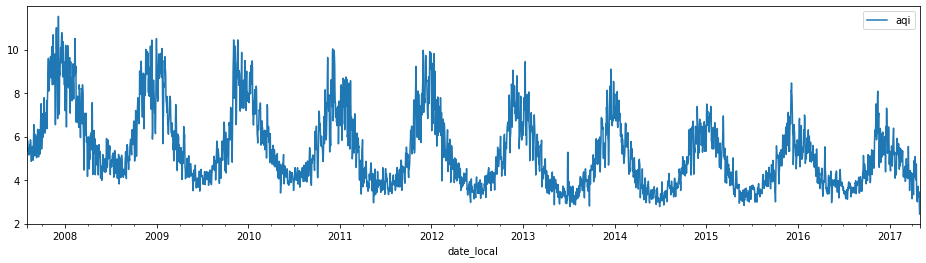

In [23]:
air_df.plot(figsize=(16,4));
# by default: index = x-axis, column = y-axis

<a id='mani'></a>

## 3. Time-based manipulations

### Easy Aggregations

Another advantage of the datetime-index approach is that it provides us with some functionality for easy time-based aggregations. One such aggregation is `resample`. 

For example, we can easily calculate the _mean_ per _year_ by running:

In [29]:
air_df.resample('Y').mean()
# resample by year (takes last day)

,aqi
date_local,
2007-12-31,7.450299
2008-12-31,6.426417
2009-12-31,6.000169
2010-12-31,5.672559
2011-12-31,5.449307
2012-12-31,5.193016
2013-12-31,4.767681
2014-12-31,4.609659
2015-12-31,4.679786


In [28]:
air_df.resample('M').median()
# resample by month (takes last day)

,aqi
date_local,
2007-08-31,5.457726
2007-09-30,5.655101
2007-10-31,7.051913
2007-11-30,9.446738
2007-12-31,9.308540
...,...
2017-01-31,5.113772
2017-02-28,5.046556
2017-03-31,4.336000


In [32]:
air_df.resample('6M').min()
# resample by every 3 months (takes last day)

,aqi
date_local,
2007-08-31,4.860947
2008-02-29,5.025568
2008-08-31,3.821429
2009-02-28,4.067647
2009-08-31,3.492114
2010-02-28,3.847352
2010-08-31,3.407895
2011-02-28,3.760656
2011-08-31,2.956954


You can also run the same aggregation per month `M`, week `W`, day `D` or quarter `Q`. Custom aggregation periods are also possible, for example per 4 weeks `4W` or per 3 months `3M`. If the index is a timestamp that also includes times, then you can also aggregate per hour. See [here] for a more comprehensive list of offsets, that can be as specific as _'Business Month Begin'_. 

[here]: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In the cell below we compute the mean AQI for consecutive 4 week periods.

In [33]:
air_df.resample('4W').mean().head()

,aqi
date_local,
2007-08-05,5.776494
2007-09-02,5.458930
2007-09-30,5.833649
2007-10-28,7.204429
2007-11-25,9.091922


We can also use general `.agg()` methods here to apply multiple aggregators, including custom aggregations. For example, the spread per month: 

In [34]:
(
    air_df
    .resample('M')
    .agg([
        ('mean','mean'),
        ('var','var'),
        ('spread', lambda month_df: month_df.max() - month_df.min())
    ])
    #.droplevel(0, axis=1)
    .head()
)

aqi                    
                mean       var    spread
date_local                              
2007-08-31  5.526863  0.126435  1.687158
2007-09-30  5.791397  0.348850  2.482906
2007-10-31  7.377305  1.181423  3.623544
2007-11-30  9.303497  0.936076  4.459595
2007-12-31  9.258700  1.286069  4.702944

In [36]:
(
    air_df
    .resample('M')
    .agg([
        ('min value','min'),
        ('max value','max'),
        ('spread', lambda month_df: month_df.max() - month_df.min())
    ])
    #.droplevel(0, axis=1)
    .head()
)

aqi                     
           min value  max value    spread
date_local                               
2007-08-31  4.860947   6.548105  1.687158
2007-09-30  5.025568   7.508475  2.482906
2007-10-31  5.969863   9.593407  3.623544
2007-11-30  6.543175  11.002770  4.459595
2007-12-31  6.821918  11.524862  4.702944

### <mark>Exercise: Resampling

Compute the average AQI per week and find the week that had the worst (or highest) AQI




In [42]:
# %load answers/resample.py
(
    air_df
    .resample('W-Mon')
    .mean()
    .sort_values(by='aqi', ascending=False)
)

,aqi
date_local,
2007-12-24,9.908962
2007-12-17,9.641383
2007-11-19,9.553734
2009-11-23,9.486983
2008-11-24,9.435048
...,...
2014-06-16,3.155085
2017-05-01,3.139388
2013-06-24,3.134838


In [46]:
air_df.resample('W-Mon').mean().sort_values(by='aqi', ascending=False).head(1)
# it calculates the week starting on Monday

,aqi
date_local,
2007-12-24,9.908962


### Time Based Features 

Any column in Pandas that is of dtype `datetime` has a module attached that can be used to perform vectorised datetime operations. This is very similar to the `.str` module attached to string columns. It is a good thing to explore since the alternative is non-vectorised and much slower.

Below is an example of getting the quarter and adding the day name. Feel free to explore [other](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#api-series-dt) properties and methods.

In [44]:
(
    air_df
    .assign(quarter = lambda df: df.index.quarter,
            weekday = lambda df: df.index.day_name())
    .head()
)

,aqi,quarter,weekday
date_local,,,
2007-08-01,5.522124,3,Wednesday
2007-08-02,5.894895,3,Thursday
2007-08-03,5.928358,3,Friday
2007-08-04,5.792285,3,Saturday
2007-08-05,5.744807,3,Sunday


### <mark>Exercise: Weekday with worst air quality</mark>

Which day of the week has the worst (or highest) on average? Does AQI drop in the weekend? 

Bonus: Make a bar plot to better illustrate any weekly air quality patterns

<AxesSubplot:title={'center':'total consumption per day of the week'}, xlabel='weekday'>

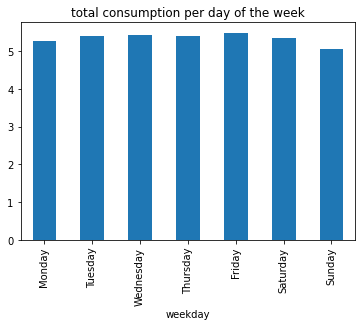

In [48]:
# %load answers/time_based_features.py
(
    air_df
    .assign(weekday = lambda df: df.index.day_name(),
            weekday_num = lambda df: df.index.day_of_week)
    .groupby('weekday')
    .mean()
    .sort_values('weekday_num')
    .plot(kind='bar', y='aqi', legend=False, title='total consumption per day of the week')
)


### BONUS: Shifting

It can be often useful to shift some variables forward or backwards in time. This can for example help us create variables with lagged values or calculate differences in values between time steps. This can be done using Panda's `shift` method, which can shift values by a given number of periods (positive or negative). 

The example below uses this method to create a new variable for AQI during the previous day:

In [54]:
(
    air_df
    .assign(aqi_yesterday = lambda df: df.aqi.shift(1))
    .assign(aqi_tomorrow = lambda df: df.aqi.shift(-1))
    .assign(change_in_aqi = lambda df: df.aqi - df.aqi_yesterday)
    #.dropna()
    .head()
)

,aqi,aqi_yesterday,aqi_tomorrow,change_in_aqi
date_local,,,,
2007-08-01,5.522124,NaN,5.894895,NaN
2007-08-02,5.894895,5.522124,5.928358,0.372771
2007-08-03,5.928358,5.894895,5.792285,0.033463
2007-08-04,5.792285,5.928358,5.744807,-0.136073
2007-08-05,5.744807,5.792285,5.398230,-0.047478


<a id='roll'></a>

## 4. Smoothing

Let us have a closer look at the air quality patterns during a single year. 

The simplest way to plot timestamp data dynamics in Pandas is using the `plot` method, which by default plots a linear plot over time:

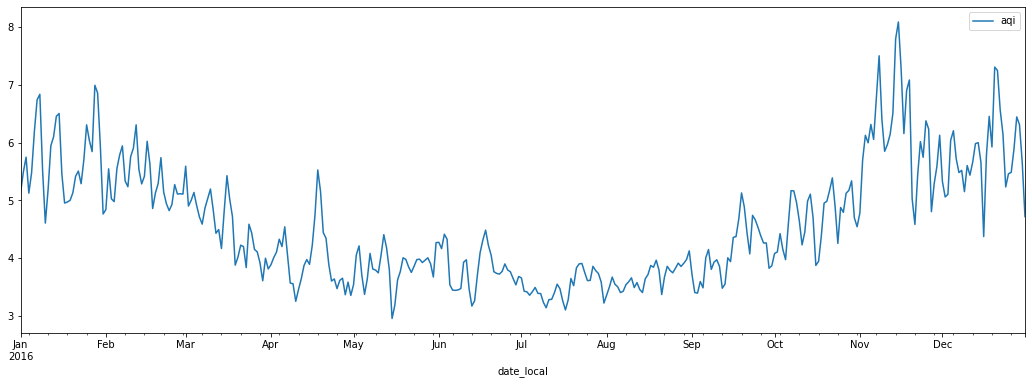

In [55]:
air_df_2016 = air_df.loc['2016']

air_df_2016.plot(figsize=(18,6));

### Rolling Average smoothing

Various patterns can be seen on this daily line graph, but the overall trend can be hard to see due to noise plentiful short spikes. 

In order to see a *smoother* pattern over time, a __rolling average__ can be applied to a Time Series. It walks over the timestamps with a given window (7 days for example) and calculates averages for each. 

Pandas can perform this via the `rolling` method which can be called on both a DataFrame as well as a Series object. The window size for this method can be set using both a fixed number of data points as well as particular time intervals (days, weeks etc).

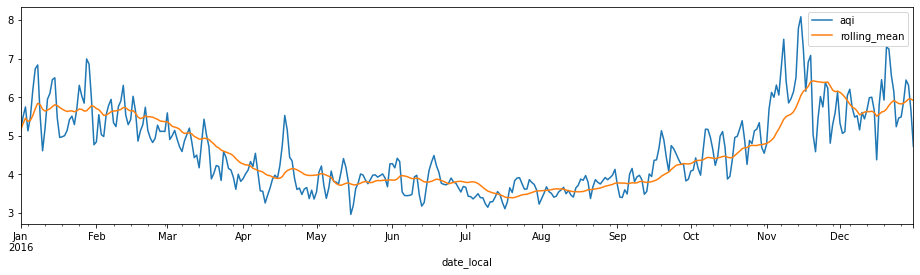

In [58]:
(
    air_df_2016
    .assign(rolling_mean=lambda df: df['aqi'].rolling('20D').mean())
    .plot(figsize=(16, 4))
);

Note that the orange *rolling mean line* is lagging behind what actually happens. This is because, by default, each point of the rolling average represents information about this day and the preceding days - not just this particular moment! We can remove this effect using *centering*.

To center the rolling mean, we can either manually shift it backwards or use the option `center=True` for the `rolling()` method. You can see below how both achieve the same result - the red and green (overlapping) lines do not lag anymore. 

__Importantly__, centering requires information from the future for each point. This makes centering bad practice if we want to further make predictions about the future — this information is then already contained in the present data points, which is referred to as *information leakage* in machine learning.

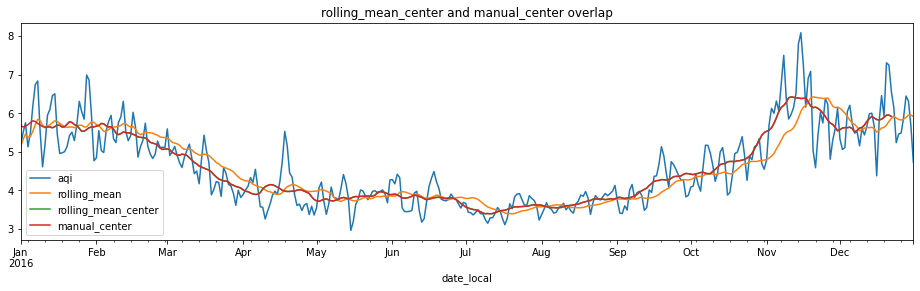

In [59]:
(
    air_df_2016
    .assign(
        rolling_mean=lambda df: df['aqi'].rolling('20D').mean(),
        # With `center=True` window size cannot be a time frame!
        rolling_mean_center=lambda df: df['aqi'].rolling(20, center=True).mean(),
        manual_center=lambda df: df['rolling_mean'].shift(-9)
    )
    .plot(figsize=(16,4), title='rolling_mean_center and manual_center overlap')
);

Rolling average smoothing is a simple way to isolate signal from noise in Time Series data and get an idea about general Time Series behavior.

However, there are some notable drawbacks:

- Highly dependent on window size: 
    - using a small window sizes can lead to more noise than signal;
    - using a large window size can remove important signal information).
- It always lags by the window size (unless centered).
- It is not really informative about the future.
- It can be significantly skewed by extreme datapoints in the past.

### <mark>Exercise: Weekday with worst air quality</mark>

In a previous exercise we saw that the week commencing Monday 24th December 2007 had the worst average air quality.


In [60]:
(
    air_df
    .resample('W-Mon')
    .mean()
    .nlargest(1, 'aqi')
)

,aqi
date_local,
2007-12-24,9.908962


However, this is not necessarilly the 7-day period that had the worst average air quality.

For example, that may span a Friday to Thursday, as opposed to Monday to Sunday.

Find the 7-day period that had the worst average air quality.


In [65]:
# %load answers/rolling.py
(
    air_df
    .rolling('7D')
    .mean()
    .nlargest(1, 'aqi')
)

,aqi
date_local,
2007-12-20,10.128208


In [68]:
air_df_2016.assign(rolling_mean=lambda df: df['aqi'].rolling('7D').mean()).sort_values(by='rolling_mean', ascending=False).head(1)

,aqi,rolling_mean
date_local,,
2016-11-19,7.082192,7.113088


### BONUS: Exponential Smoothing

An alternative to calculating the rolling statistics is to smooth the timeseries exponentially with the following formula:

$$\hat{y_t} = \alpha y_t + (1-\alpha) \hat{y}_{t-1}$$

where $\hat{y_t}$ is the output of the exponential smoothing at time $t$, $y_t$ is the data point at time $t$, and $0<\alpha<1$ is the *the smoothing factor*.


The idea is to recursively smooth the series by averaging the current average with the current value. If $\alpha$ is high then the smoothing will be low but the average can respond quicker to changes, and if it is low — the result will be much more smooth and flat.

In [ ]:
(
    air_df_2016
    .assign(
        smoothed_01=lambda df: df['aqi'].ewm(alpha=0.1).mean(),
        smoothed_001=lambda df: df['aqi'].ewm(alpha=0.01).mean()
    )
    .plot(figsize=(16, 4))
);

Exponential Smoothing exhibits reduced lagging and more weight assigned to the current timestamps compared to Simple Rolling Averages, which also makes it more informative about the future. You can read more about EWM (exponentially weighted Moving average) in the pandas [docs].

[docs]: https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

Other alternatives are [weighted smoothing](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#rolling-windows) and [expanding windows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.expanding.html). 

<a id='sum'></a>
## 5. Summary

We have covered: 
- Timestamps and formatting in Pandas
- How to properly read in Time Series data in Pandas, and why it is important to set the date as an index
- Time based manipulations, such as aggregations with `resample`, time-based features based on dtype `datetime` and shifting
- Smoothing with rolling averages, its disadvantages and some alternatives.

We should now be able to answer analytics questions like: 
- Which year had the worst air quality?
- Which five day period had the largest decrease in air quality (between the first and last day)?
- Does air quality improve over the weekend? 
